# Comparison of some data structures

# Table of contents

0. [Reading dataset](#0-reading-dataset)
1. [Compare normalized sigmut / non normalized sigmut](#1-compare-normalized-nonnormalized)
2. [Compare fully connected graph and expert knowledge built graph](#2-compare-fc-expert)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.BinaryClassifierTrainTestManager import BinaryClassifierTrainTestManager
from manage.GCNClassifierTrainTestManager import GCNClassifierTrainTestManager

from models.BinaryClassifier import BinaryClassifier
from models.GCNClassifier import GCNClassifier

from utils.preProcessing import preProcessing

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, manhattan_distances
from sklearn.preprocessing import StandardScaler

## 0. Reading dataset and preprocessing

In [2]:
## No mutational signatures
df_no_sigmut = pd.read_excel('data/Supplemental-table1.xlsx')
df_no_sigmut = df_no_sigmut.loc[df_no_sigmut["Cohort"] == "Naive"]
df_no_sigmut = preProcessing.delete_nan_values(df_no_sigmut)


## Mutational signatures
df_sigmut = pd.read_excel('data/table-s1-sigmut-indel.xlsx')
df_sigmut = df_sigmut.loc[df_sigmut["Cohort"] == "Naive"]
df_sigmut = preProcessing.delete_nan_values(df_sigmut)

## 1. Compare normalized / non normalized mutational signatures
We can see in the table that the mutational signatures contains a lot of 0 values. So, the mean is around 0 and the standard deviation is low. So the normalized data may be high, and maybe can cause problem on predictions. So we test the case where we normalize these mutational signatures, and the case where we do not normalized them.

We use the KMeans euclidean method to build the graph.

### No sigmut

In [3]:
# Select and normalize features
features_name_no_sigmut = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]
X_no_sigmut = df_no_sigmut.loc[:,features_name_no_sigmut].to_numpy()
# Normalize data
X_no_sigmut = preProcessing.normalize_data(X_no_sigmut)
# Numerize label
label_name = "Clinical benefit"
y_no_sigmut = np.where(df_no_sigmut[label_name]=="DCB",1,0)

In [4]:
# Instanciate GCN classifier
gcn_clf_no_sigmut_kmeans_euclidean = GCNClassifier(len(features_name_no_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_no_sigmut_kmeans_euclidean = GCNClassifierTrainTestManager(gcn_clf_no_sigmut_kmeans_euclidean)

In [5]:
# Distance matrix no sigmut
distance_matrix_euclidean_no_sigmut = euclidean_distances(X_no_sigmut)

# Group labels for connecting patients (kmeans clusters)
group_no_sigmut_kmeans_euclidean = KMeans(n_clusters=10).fit(distance_matrix_euclidean_no_sigmut).labels_

## Leave one out CV
test_scores_gcn_no_sigmut_kmeans_euclidean, test_classes_gcn_no_sigmut_kmeans_euclidean = gcn_manager_no_sigmut_kmeans_euclidean.leave_one_out_cross_validation(X_no_sigmut, y_no_sigmut, group_no_sigmut_kmeans_euclidean, 50, "euclidean", 3)

/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Non-normalized

In [6]:
# Select features
features_name_sigmut = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression","SBS1","SBS2","SBS3","SBS4","SBS5","SBS7a","SBS7b","SBS7c","SBS7d","SBS8","SBS10a","SBS10b","SBS10c","SBS13","SBS15","SBS17a","SBS17b","SBS18","SBS31","SBS35","SBS36","SBS37","SBS38","SBS40","SBS44","SBS4426","ID1","ID2","ID3","ID4","ID5","ID6","ID7","ID8","ID9","ID10","ID11","ID12","ID13","ID14","ID15","ID16","ID17","ID18"]
features_to_normalize = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]

# Normalize features except mutational signatures
df_sigmut.loc[:,features_to_normalize] = StandardScaler().fit_transform(df_sigmut.loc[:,features_to_normalize].to_numpy())
display(df_sigmut)

# Extract features
X_sigmut_non_normalized = df_sigmut.loc[:,features_name_sigmut].to_numpy()

# Numerize label
y_sigmut = np.where(df_sigmut[label_name]=="DCB",1,0)

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,ID9,ID10,ID11,ID12,ID13,ID14,ID15,ID16,ID17,ID18
0,28123.0,EGAD00001003065,ACC,M,2,"Tremelimumab, Durvalumab",Naive,Progression,Progressive disease,-0.999720,...,0.212,0.154,0.000,0.100,0.0,0.000,0.0,0.0,0.000,0.0
1,38313.0,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,-1.451384,...,0.000,0.186,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0
2,18624.0,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,-0.472779,...,0.000,0.000,0.000,0.000,0.0,0.049,0.0,0.0,0.000,0.0
3,28430.0,EGAD00001003085,AECA,F,1,Pembrolizumab,Naive,Progression,Progressive disease,0.129440,...,0.087,0.000,0.000,0.000,0.0,0.049,0.0,0.0,0.076,0.0
4,23701.0,EGAD00001002576,BRCA,F,7,"GEMCITABINE, VINORELBINE, PEMBROLIZUMAB (ARIZONA)",Naive,Progression/death,Progressive disease,-1.752494,...,0.091,0.000,0.000,0.000,0.0,0.054,0.0,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,25603.0,EGAD00001002631,UCEC,F,3,Nivolumab +IDO1 inhibitor (BMS986205),Naive,Progression,Progressive disease,0.957491,...,0.149,0.132,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0
87,27792.0,EGAD00001003059,UCEC,F,4,Monalizumab,Naive,Progression,Progressive disease,0.204718,...,0.121,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0
88,34211.0,EGAD00001004636,UCEC,F,4,"NIVOLUMAB (P1T986205),BMS-986205 (P1T986205)/I...",Naive,Progression,Progressive disease,-1.074998,...,0.165,0.000,0.000,0.117,0.0,0.000,0.0,0.0,0.000,0.0
92,32667.0,EGAD00001004605,UVM,F,1,Pembrolizumab,Naive,Progression,Physician assessed PD,0.355272,...,0.000,0.189,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0


In [7]:
# Instanciate GCN classifier
gcn_clf_sigmut_non_normalized_kmeans_euclidean = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_sigmut_non_normalized_kmeans_euclidean = GCNClassifierTrainTestManager(gcn_clf_sigmut_non_normalized_kmeans_euclidean)

In [8]:
# Distance matrix sigmut non normalized
distance_matrix_euclidean_sigmut_non_normalized = euclidean_distances(X_sigmut_non_normalized)

# Group labels for connecting patients (kmeans clusters)
group_sigmut_non_normalized_kmeans_euclidean = KMeans(n_clusters=10).fit(distance_matrix_euclidean_sigmut_non_normalized).labels_

## Leave one out CV
test_scores_gcn_sigmut_non_normalized_kmeans_euclidean, test_classes_gcn_sigmut_non_normalized_kmeans_euclidean = gcn_manager_sigmut_non_normalized_kmeans_euclidean.leave_one_out_cross_validation(X_sigmut_non_normalized, y_sigmut, group_sigmut_non_normalized_kmeans_euclidean, 50, "euclidean", 3)

/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Normalized

In [9]:
# Normalize features except mutational signatures
df_sigmut.loc[:,features_name_sigmut] = StandardScaler().fit_transform(df_sigmut.loc[:,features_name_sigmut].to_numpy())
display(df_sigmut)

# Extract features
X_sigmut_normalized = df_sigmut.loc[:,features_name_sigmut].to_numpy()

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,ID9,ID10,ID11,ID12,ID13,ID14,ID15,ID16,ID17,ID18
0,28123.0,EGAD00001003065,ACC,M,2,"Tremelimumab, Durvalumab",Naive,Progression,Progressive disease,-0.999720,...,0.958757,1.302554,-0.335281,3.434012,-0.375603,-0.315627,-0.111111,-0.385984,-0.327410,-0.233086
1,38313.0,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,-1.451384,...,-0.892313,1.708480,-0.335281,-0.223938,-0.375603,-0.315627,-0.111111,-0.385984,-0.327410,-0.233086
2,18624.0,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,-0.472779,...,-0.892313,-0.650968,-0.335281,-0.223938,-0.375603,0.521461,-0.111111,-0.385984,-0.327410,-0.233086
3,28430.0,EGAD00001003085,AECA,F,1,Pembrolizumab,Naive,Progression,Progressive disease,0.129440,...,-0.132676,-0.650968,-0.335281,-0.223938,-0.375603,0.521461,-0.111111,-0.385984,3.465186,-0.233086
4,23701.0,EGAD00001002576,BRCA,F,7,"GEMCITABINE, VINORELBINE, PEMBROLIZUMAB (ARIZONA)",Naive,Progression/death,Progressive disease,-1.752494,...,-0.097750,-0.650968,-0.335281,-0.223938,-0.375603,0.606878,-0.111111,-0.385984,-0.327410,-0.233086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,25603.0,EGAD00001002631,UCEC,F,3,Nivolumab +IDO1 inhibitor (BMS986205),Naive,Progression,Progressive disease,0.957491,...,0.408675,1.023479,-0.335281,-0.223938,-0.375603,-0.315627,-0.111111,-0.385984,-0.327410,-0.233086
87,27792.0,EGAD00001003059,UCEC,F,4,Monalizumab,Naive,Progression,Progressive disease,0.204718,...,0.164194,-0.650968,-0.335281,-0.223938,-0.375603,-0.315627,-0.111111,-0.385984,-0.327410,-0.233086
88,34211.0,EGAD00001004636,UCEC,F,4,"NIVOLUMAB (P1T986205),BMS-986205 (P1T986205)/I...",Naive,Progression,Progressive disease,-1.074998,...,0.548378,-0.650968,-0.335281,4.055863,-0.375603,-0.315627,-0.111111,-0.385984,-0.327410,-0.233086
92,32667.0,EGAD00001004605,UVM,F,1,Pembrolizumab,Naive,Progression,Physician assessed PD,0.355272,...,-0.892313,1.746536,-0.335281,-0.223938,-0.375603,-0.315627,-0.111111,-0.385984,-0.327410,-0.233086


In [10]:
# Instanciate GCN classifier
gcn_clf_sigmut_normalized_kmeans_euclidean = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_sigmut_normalized_kmeans_euclidean = GCNClassifierTrainTestManager(gcn_clf_sigmut_normalized_kmeans_euclidean)

In [11]:
# Distance matrix sigmut non normalized
distance_matrix_euclidean_sigmut_normalized = euclidean_distances(X_sigmut_normalized)

# Group labels for connecting patients (kmeans clusters)
group_sigmut_normalized_kmeans_euclidean = KMeans(n_clusters=10).fit(distance_matrix_euclidean_sigmut_normalized).labels_

## Leave one out CV
test_scores_gcn_sigmut_normalized_kmeans_euclidean, test_classes_gcn_sigmut_normalized_kmeans_euclidean = gcn_manager_sigmut_normalized_kmeans_euclidean.leave_one_out_cross_validation(X_sigmut_normalized, y_sigmut, group_sigmut_normalized_kmeans_euclidean, 50, "euclidean", 3)

/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Compare

In [12]:
## No sigmut
acc_gcn_no_sigmut_kmeans_euclidean, pre_gcn_no_sigmut_kmeans_euclidean, rec_gcn_no_sigmut_kmeans_euclidean, f1_gcn_no_sigmut_kmeans_euclidean = ClassificationMetrics.eval_metrics_from_conf_matrix(y_no_sigmut, test_classes_gcn_no_sigmut_kmeans_euclidean)
fpr_gcn_no_sigmut_kmeans_euclidean, tpr_gcn_no_sigmut_kmeans_euclidean, thresholds_gcn_no_sigmut_kmeans_euclidean = ClassificationMetrics.compute_roc_curve(y_no_sigmut, test_scores_gcn_no_sigmut_kmeans_euclidean)
auc_gcn_no_sigmut_kmeans_euclidean = ClassificationMetrics.compute_auc(y_no_sigmut, test_scores_gcn_no_sigmut_kmeans_euclidean)

## Sigmut non normalized
acc_gcn_sigmut_non_normalized_kmeans_euclidean, pre_gcn_sigmut_non_normalized_kmeans_euclidean, rec_gcn_sigmut_non_normalized_kmeans_euclidean, f1_gcn_sigmut_non_normalized_kmeans_euclidean = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_sigmut_non_normalized_kmeans_euclidean)
fpr_gcn_sigmut_kmeans_non_normalized_euclidean, tpr_gcn_sigmut_kmeans_non_normalized_euclidean, thresholds_gcn_sigmut_non_normalized_kmeans_euclidean = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_sigmut_non_normalized_kmeans_euclidean)
auc_gcn_sigmut_kmeans_non_normalized_euclidean = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_sigmut_non_normalized_kmeans_euclidean)

## Sigmut normalized
acc_gcn_sigmut_normalized_kmeans_euclidean, pre_gcn_sigmut_normalized_kmeans_euclidean, rec_gcn_sigmut_normalized_kmeans_euclidean, f1_gcn_sigmut_normalized_kmeans_euclidean = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_sigmut_normalized_kmeans_euclidean)
fpr_gcn_sigmut_kmeans_normalized_euclidean, tpr_gcn_sigmut_kmeans_normalized_euclidean, thresholds_gcn_sigmut_normalized_kmeans_euclidean = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_sigmut_normalized_kmeans_euclidean)
auc_gcn_sigmut_kmeans_normalized_euclidean = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_sigmut_normalized_kmeans_euclidean)


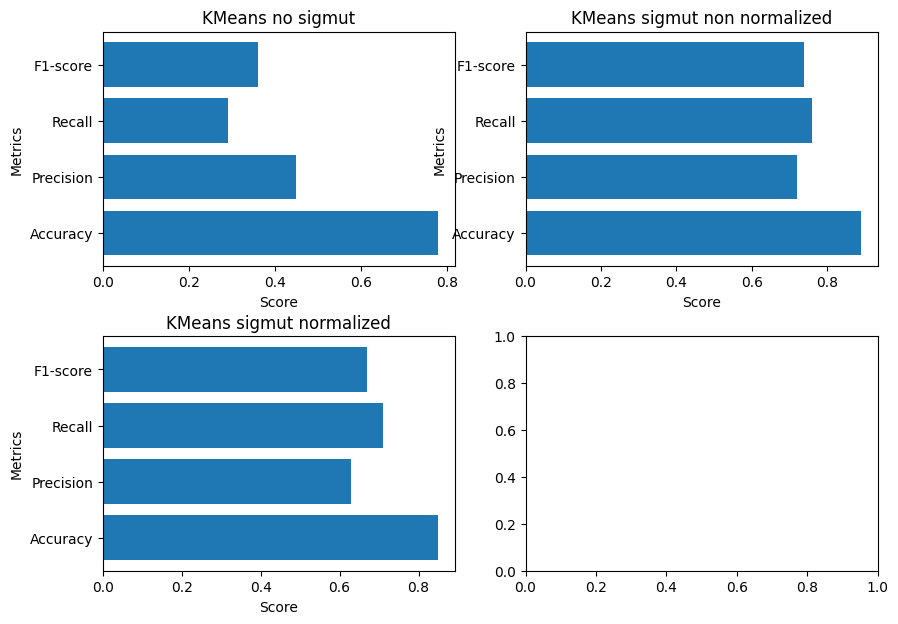

In [17]:
fig, ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_no_sigmut_kmeans_euclidean, pre_gcn_no_sigmut_kmeans_euclidean, rec_gcn_no_sigmut_kmeans_euclidean, f1_gcn_no_sigmut_kmeans_euclidean])
ax[0,0].set_xlabel("Score")
ax[0,0].set_ylabel("Metrics")
ax[0,0].set_title("KMeans no sigmut")

ax[0,1].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_sigmut_non_normalized_kmeans_euclidean, pre_gcn_sigmut_non_normalized_kmeans_euclidean, rec_gcn_sigmut_non_normalized_kmeans_euclidean, f1_gcn_sigmut_non_normalized_kmeans_euclidean])
ax[0,1].set_xlabel("Score")
ax[0,1].set_ylabel("Metrics")
ax[0,1].set_title("KMeans sigmut non normalized")

ax[1,0].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_sigmut_normalized_kmeans_euclidean, pre_gcn_sigmut_normalized_kmeans_euclidean, rec_gcn_sigmut_normalized_kmeans_euclidean, f1_gcn_sigmut_normalized_kmeans_euclidean])
ax[1,0].set_xlabel("Score")
ax[1,0].set_ylabel("Metrics")
ax[1,0].set_title("KMeans sigmut normalized")

plt.subplots_adjust(hspace=0.3)

Text(0, 0.6, 'AUC sigmut normalized : 0.94')

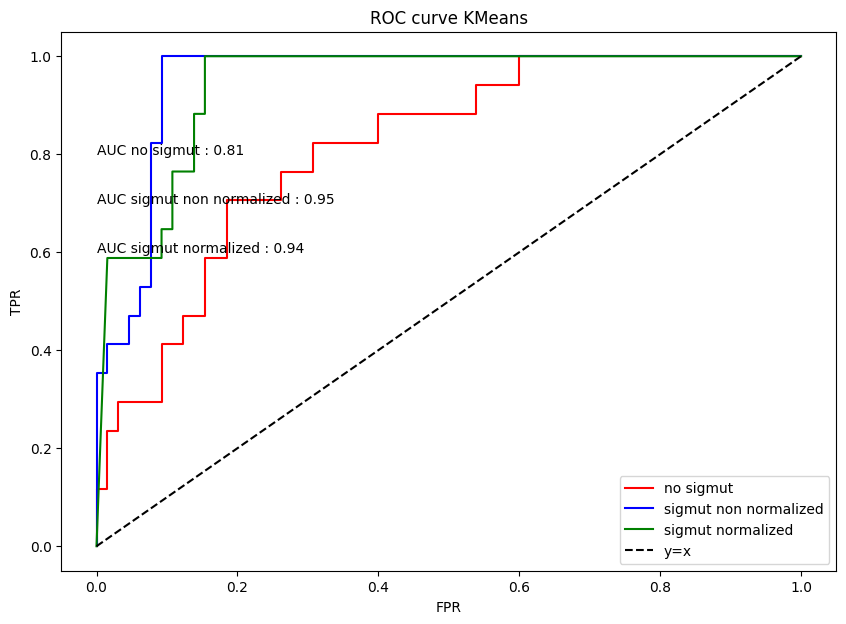

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
x = np.linspace(0,1,100)

# No sigmut :
ax.plot(fpr_gcn_no_sigmut_kmeans_euclidean, tpr_gcn_no_sigmut_kmeans_euclidean, color='red',label='no sigmut')
ax.plot(fpr_gcn_sigmut_kmeans_non_normalized_euclidean, tpr_gcn_sigmut_kmeans_non_normalized_euclidean, color='blue',label='sigmut non normalized')
ax.plot(fpr_gcn_sigmut_kmeans_normalized_euclidean, tpr_gcn_sigmut_kmeans_normalized_euclidean, color='green',label='sigmut normalized')
ax.plot(x,x,linestyle='--',color='black',label='y=x')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC curve KMeans')
ax.legend()
ax.text(0,0.8,f"AUC no sigmut : {auc_gcn_no_sigmut_kmeans_euclidean}")
ax.text(0,0.7,f"AUC sigmut non normalized : {auc_gcn_sigmut_kmeans_non_normalized_euclidean}")
ax.text(0,0.6,f"AUC sigmut normalized : {auc_gcn_sigmut_kmeans_normalized_euclidean}")